# Feature Engineering to Predict the Number of Likes of a Youtube Video

## Introduction
Predicting the likes of a youtube video is a fairly open ended problem and the factors involved in solving this problem are endless. From a basic exploration we can see that the likes of a youtube videos will depend on number of views, popularity of the channel, popularity of the person or issue being talked about, etc. The list can go on. It is not possible to account for all the possible factors as some of them can’t be quantified for eg, there is no way(yet!) to judge video content. Here I have attempted to explore as many new features as I could get my hands on in the given time period and I believe I have come up with some interesting results.

## Packages Used
* Python2, 3
* MongoDB
* Sklearn
* Pandas
* Numpy
* Matplotlib
* YTCrawl
* Youtube data API
* Selenium

# Feature Engineering
### Most Interesting Features
* **adwords_data**
    * each youtube video has tags associated with it and I am using adwords keyword planner to get average monthly searches, bid, competition and I am taking the average for all tags of a video
    * This is very interesting as this is an attempt to try and analyse the way the populus **thinks about the video!**
* __**backlinks of youtube videos**__
    This tracks in how many places has the current video been cited
* timeseries data
    * finding the gradient of the time series data shows the trend of the video which will effect the total likes. Generally videos with fluctuating grads will have low likes.
    * variance of the time series data shows if the video has been attracting views, shares, etc in a similar range or not and if yes how varied is that
* Channel Features
    * I believe considering the channel features is what made all the difference in the result.
    * The channel plays a huge role in the number of likes a video gets.
    
#### Few Interesting Features I have not yet used but could be used
* featured_channels - this is a list of channels that are featured on a channel. The number of featured channels and the various stats of these channels can possibly be used to improve the result.

## Data Generation
#### Steps in Data Generation
1. **Extract video ids**
    * Using *trending_and_playlist_extract* we first get the trending videos from all countries and all videos from any playlist. I decided to use only the videos contained in the playlists by the channel <https://www.youtube.com/channel/UCEDEKrjFZFp3Br3ENlYomdA>.
    * After a little processing we can extract the id of the video from the url.
    * These ids are then stored into a mongo collection.
2. **Get features from video ids**
    * Using *get_yt_features*, which calls *yt_page_interact's module get_video_stats* we extract the features using the ids collected in the previous step.
    * After making the above script I found a better way to do the task using youtube data api and a [crawler I found on github](https://github.com/yuhonglin/YTCrawl). These methods allowed me to get some extra data which I was not able to get before(specifically, time series data of views, watch time, subcriptions driven and shares) and they were more stable than my scripts.
    * Now, using *get_store_features* which uses *data_extraction_util* we get the features of all the youtube video ids stored before.
    * these features are again stores into a mongdb collection.
3. **Total Features Collected** - 26
    1. backlinks
    1. category_id
    1. channel_comment_count
    1. channel_publish
    1. channel_subscribers
    1. channel_video_count
    1. channel_view_count
    1. comment_count
    1. dislike_count
    1. likes_count
    1. upload_data
    1. daily_views_var
    1. daily_views_grad
    1. daily_views_tot
    1. shares_var
    1. shares_grad
    1. shares_tot
    1. subscribers_var
    1. subscribers_grad
    1. subscribers_tot
    1. watch_time_var
    1. watch_time_grad
    1. watch_time_tot
    1. searches
    1. bid
    1. competition

## Preprocessing Data
A lot of the training samples had missing data. I first worked to impute the missing data but that did not yield any succesful results. Then I decided to remove any sample that had missing data and was left with 733 samples with which I worked.
preprocessing of the data has been done in *preprocess_data module in process_data* which is displayed below:
```python
def preprocess_data(dic):
    # a pymongo curser is passed into the function which is converted to pandas dataframe
    df = pd.DataFrame(list(dic))

    for i in df.columns:
        # channel_publish is a string the time from publish function converts it into int
        # which denotes days from publishing
        if i == 'channel_publish':
            temp = list(df[i])
            for j in range(len(temp)):
                temp[j] = time_from_publish(temp[j])
            df[i] = temp
        try:
            # converting whatever is possible into int
            df[i] = df[i].astype(int)
        except Exception as e:
            print(e)
            try:
                # we have time series data for watch_time, shares, subcribtions_driven and views
                # calculating the varience, sum of gradient and sum to input as features 
                var = []
                grad = []
                tot = []
                for j in range(len(df)):
                    var.append(np.var(df[i][j]))
                    grad.append(np.gradient(df[i][j]).sum())
                    tot.append(np.sum(df[i][j]))
                df[i + '_var'] = var
                df[i + '_grad'] = grad
                df[i + '_tot'] = tot
            except Exception as ex:
                print(ex)
    # dropping all the values which are not needed
    df = df.drop(['daily_views', '_id', 'channel_id', 'featured_channels', 'shares', 'subscribers', 'tags', 'watch_time'], axis=1)
    return df
```

In [1]:
# importing all nessacary modules
# these include modules made by me too
import pandas as pd
import numpy as np
from pymongo import MongoClient
from sklearn.preprocessing import MinMaxScaler
import process_data as pro
from ml_scripts import train_models
from pandas.tools.plotting import radviz
import matplotlib.pyplot as plt

In [2]:
%%capture
# creating a mongo client object and setting up the db
client = MongoClient()
db = client.precog

# creating a getting a mongo curser with the data we need
# PLEASE REPLACE complete_remove WITH THE NAME OF YOUR MONGO COLLECTION
dic = db.precog.find()

# process the data using preprocess_data in process_data
# this function returns a pandas dataframe
df = pro.preprocess_data(dic)

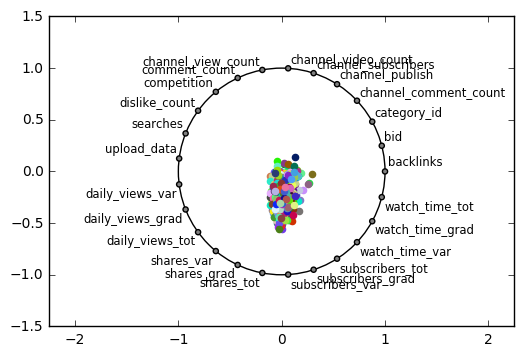

In [3]:
# lets visualize the data using radviz plot
plt.figure()
ax = radviz(df, 'likes_count')
ax.legend_.remove()
plt.show()

We can see that the data is not separable and hence a neural net based model should be effective.
The data needs to normalised first though. since the points are not separable it is essential that we do feature scaling to avoid features getting extra weights for having large values.

In [4]:
# It gives a deprecation warning, i want to ignore that for now
import warnings
warnings.filterwarnings("ignore")

# now we will normalize the data using mix max scaler
mms = MinMaxScaler()
for i in df.columns:
    df[i] = pd.DataFrame(mms.fit_transform(df[i].values))
df.describe()

,backlinks,bid,category_id,channel_comment_count,channel_publish,channel_subscribers,channel_video_count,channel_view_count,comment_count,competition,...,daily_views_tot,shares_var,shares_grad,shares_tot,subscribers_var,subscribers_grad,subscribers_tot,watch_time_var,watch_time_grad,watch_time_tot
count,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,...,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000
mean,0.046226,0.135432,0.257195,0.013846,0.514349,0.233675,0.032191,0.215536,0.089578,0.100444,...,0.119978,0.007431,0.914605,0.107927,0.014663,0.875473,0.120029,0.011677,0.898085,0.119714
std,0.062029,0.134521,0.118821,0.055696,0.218667,0.224108,0.074218,0.207605,0.118224,0.119760,...,0.140611,0.055249,0.069263,0.124684,0.084994,0.061626,0.131280,0.053231,0.067370,0.144379
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.014642,0.039865,0.214286,0.000021,0.339985,0.058943,0.007392,0.054555,0.025173,0.024272,...,0.039090,0.000050,0.915960,0.032362,0.000138,0.871528,0.038313,0.000324,0.899145,0.037188
50%,0.029486,0.105401,0.214286,0.000447,0.563526,0.172394,0.012769,0.142751,0.049269,0.058252,...,0.075657,0.000256,0.938187,0.068393,0.000675,0.894688,0.077335,0.001285,0.917032,0.072106
75%,0.054345,0.182512,0.214286,0.007400,0.657994,0.325864,0.023017,0.319147,0.108751,0.133914,...,0.141591,0.001544,0.944390,0.137946,0.002961,0.901325,0.147722,0.005522,0.920964,0.135964
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


started models
started trining
rbf done
rbf...;---
mean_squared_error 0.00521816135842
r2_score 0.590315818041


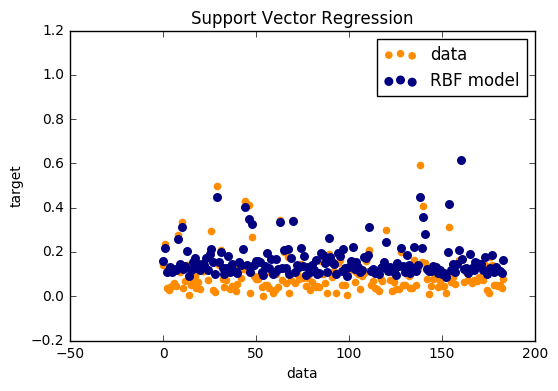

ANN...
mean_squared_error 0.00173963958785
r2_score 0.863418784415


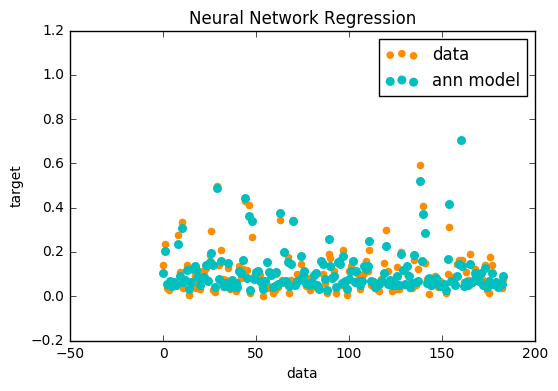

In [5]:
# training using train_models from ml_tests
# it trains using SVM with RBF kernel and ann
train_models(df.drop('likes_count', axis=1), df['likes_count'])

As we can see we get a better result from the neural net than SVM. I have seen highest **r2_score** for this to be **0.9** which is great considering the problem. Now lets see how our algorithm is doing.

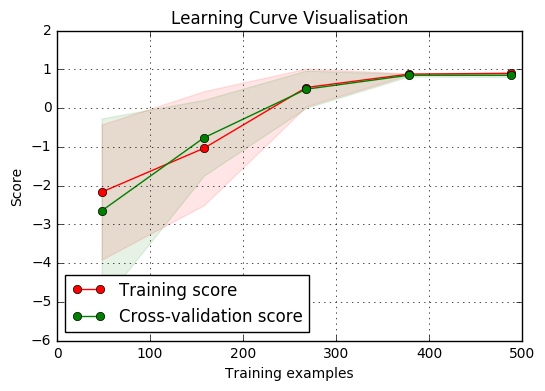

In [6]:
# Now let's visualise the learning curve to see how our algorithm is doing
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import learning_curve

plt.figure()
plt.title('Learning Curve Visualisation')
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(MLPRegressor(hidden_layer_sizes=(100,100,100,), activation='relu'), df.drop('likes_count', axis=1), df['likes_count'])
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

As we can see that at the end both the curves converge to a value close to 1 and hence our algorithm is working pretty great.
It took just 200 examples to get to a flat value(at the time i am writing this) which is **amazing**.